In [2]:
from imblearn.under_sampling import NearMiss, ClusterCentroids
from imblearn.over_sampling import SMOTE
from my_functions import *
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import f1_score
from matplotlib.pyplot import savefig
from statistics import mean

def sampling_strategy(X,y,n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy



# - # UNDER & OVER SAMPLING # - #
15fps.csv
--- SVC


/home/bobsync/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bobsync/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bobsync/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Testing [5]:

              precision    recall  f1-score   support

           0       0.19      0.20      0.19      1987
           1       0.16      0.21      0.18      1537
           2       0.00      0.00      0.00       517
           3       0.56      0.63      0.59      5346
           4       0.00      0.00      0.00       619

    accuracy                           0.41     10006
   macro avg       0.18      0.21      0.19     10006
weighted avg       0.36      0.41      0.38     10006



FileNotFoundError: [Errno 2] No such file or directory: '../confusion_matrix/resampled/NearMiss/15fps/ID5_SVC_True_scale.png'

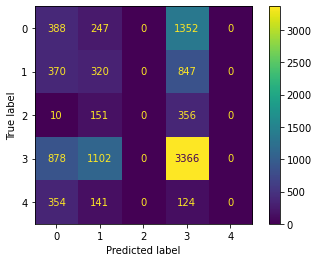

In [12]:
print("\n# - # UNDER & OVER SAMPLING # - #")
#print(f"Resampling dei file: {groundtruth_list}\n")

toScale = True

for file in ["15fps.csv", "20fps.csv", "25fps.csv"]:

    file_name = file.split(".")[0]
    print(file)

    # Reading the csv file
    df = pd.read_csv(f'../groundtruth/sequence/{file_name}.csv')
    df.drop(["inizio", "fine"], axis=1, inplace=True)
    ids_list = df["id"].unique()

    for model in [SVC, RandomForestClassifier]:

        # model name to pretty print
        model_name = str(model).split(".")[-1][:-2]
        print("--- " + model_name)

        for undersample in [NearMiss, ClusterCentroids]:

            # undersampling
            name_undersampling = str(undersample).split(".")[-1][:-2]

            with open(f'../reports/leave_one_out/resampled/{name_undersampling}/{file_name}_{model_name}_{str(toScale)}_scale.txt', 'w') as f:

                total = len(ids_list)

                f1_list = []
                printProgressBar(0, total, prefix = name_undersampling)

                for i, id in enumerate(ids_list):

                    df_train, df_test = df[df["id"] != id], df[df["id"] == id]

                    df_test = df_test.drop("id", axis=1).copy()

                    features = []
                    for feature in df_train.columns:
                        if feature not in ["id", "classe"]:
                            features.append(feature)
                    X = df_train[features]
                    y = df_train[["id", 'classe']]

                    count = y.value_counts()
                    new_y = y["id"].astype(str) + "_" + y["classe"].astype(str)
                    n_samples = count.mean().astype(np.int64)

                    under_sampler = undersample(sampling_strategy=sampling_strategy(X, new_y, n_samples, t="majority"))
                    X_under, y_under = under_sampler.fit_resample(X.copy(), new_y.copy())

                    # oversampling
                    over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under,n_samples, t='minority'),k_neighbors=2)
                    X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

                    # rimetto le colonne come prima
                    new_y_bal = y_bal.str.split('_')
                    df3 = pd.DataFrame(new_y_bal.to_list(), columns=['id','classe'])
                    df3['classe'] = df['classe'].astype(int)

                    # ricreo il df iniziale
                    new_df = pd.concat([X_bal, df3], axis=1)

                    # train test split
                    train   = new_df.drop("id", axis = 1).copy()
                    X_train = train.drop("classe", axis=1).copy()
                    y_train = train["classe"].copy()
                    X_test  = df_test.drop("classe", axis=1).copy()
                    y_test  = df_test["classe"].copy()

                    # Creo e alleno il modello
                    clf = model()
                    clf.fit(X_train, y_train)
                    
                    # Predict sul modello allenato
                    p_test = clf.predict(X_test)

                    # Report sul test
                    report = classification_report(y_test, p_test)

                    # Salvo i risultati in un file txt
                    if int(id) // 10 == 0: id = f"0{id}"
                    line = f"Testing [{id}]:\n\n{report}"
                    f.write(line)
                    print(line)

                    # Confusion Matrix
                    plot_confusion_matrix(clf, X_test, y_test)
                    savefig(f"../confusion_matrix/resampled/{name_undersampling}/{file_name}/ID{id}_{model_name}_{str(toScale)}_scale.png")

                    printProgressBar(i+1, total, prefix = name_undersampling)